# Module imports

In [31]:
import numpy as np
import random as rnd
import matplotlib.pyplot as plt
import math
import matplotlib as mpl

In [32]:
np.random.seed(30)

In [33]:
# other parameters
n = 2**10
t = 10000
p = 0.02178
omega = 1
b = 1
size = 1
k = 1.5
M = 500
d = 1.12

# Models

In [34]:
# agent behaviors for buying, selling and holding based on the probability of trading p
def buy_sell_hold(p, amount_times):
    assert p <= 0.5, "p should be smaller than 0.5"
    psis = np.zeros(amount_times)
    dice_rolls = np.random.uniform(0, 1, amount_times)
    indices = np.nonzero(dice_rolls <= 2*p)

    for index in indices[0]:
        if np.random.randint(0,2) == 0:
            psis[index] = 1
        else:
            psis[index] = -1
    return psis

In [35]:
# Agent model w noise

class Model:
    def __init__(self, p: float, n: int, size: int, k: int, omega: int, b: int) -> None:
        self.n = n
        self.p = p
        self.daily_return = 1
        self.trading_volume = 0
        self.k = k
        self.omega = omega
        self.daily_returns = []
        self.count = 0
        self.b = b

        self.daily_trading_volumes = []

        
    def distribute_opinion_groups(self) -> int:
        if self.b == 0:
            # number of opinion groups
            c = (self.n / abs(self.daily_return)) ** self.omega
                
        else:
            mean = (self.n / abs(self.daily_return)) ** self.omega

            
            c = np.random.normal(loc = mean, scale = math.sqrt(mean * self.b))
            c = int(np.round(c))
            # because logically there can only be a minimum of 1 opinion group, i.e. all agents have the same opinion, we set the minimum c to be 1.
            if c <= 0:
                c = 1
            if abs(self.daily_return) >= self.n:
                c = 1
        # rounding, as we can only have whole number of opinion groups
        c = int(np.round(c))

        # number of opnion groups can maximally be the number of agents
        c = np.min([c, self.n])
            
        return c

    def step(self):
        self.count += 1
        # distribute agents among opinion groups 
        c = self.distribute_opinion_groups()
        psis = buy_sell_hold(self.p, c)
        average_agents_per_group = int(np.round(self.n/c))
        # calculate returns and trading volume
        return_matrix = psis * average_agents_per_group
        trading_volume = np.sum(np.abs(return_matrix))
        self.daily_return = np.sum(return_matrix) #* k

         # following the boundry conditions on returns from Feng et al. 2012 appendix 5:
        minimum_return = self.n**((self.omega-1)/self.omega)
        if np.abs(self.daily_return) < minimum_return:
            sign = -1 if self.daily_return < 0 else 1
            self.daily_return = sign*minimum_return
        maximum_return = self.n
        if np.abs(self.daily_return) > maximum_return:
            self.daily_return = np.sign(self.daily_return)*maximum_return

        self.daily_returns.append(self.daily_return)
        self.daily_trading_volumes.append(trading_volume)

        return self.count

In [36]:
class Stochastic_Model:
    def __init__(self, n: int, p: float, init: int, time_horizon: bool, M, d):
        self.returns = [init]
        self.n = n
        self.p = p
        self.time_horizon = time_horizon
        self.M = M
        self.d = d

    def time_horizons(self):
        time_horizons = []
        alpha = []

        # distribution of agents in different time horizons
        # agents are allocated to each time horizon (with exponential decay as we go back in time), until we reach the limit M
        # or until we reach the beginning of the simulation (if current timestep t < M)
        for i in range(1, self.M + 1):
            if len(self.returns) == 1:
                value = (i ** -self.d) * abs(self.returns[-1])
                alpha_val = (i ** -self.d)
                time_horizons.append(value)
                alpha.append(alpha_val)

            elif i >= len(self.returns):
                value = (i ** -self.d) * abs(self.returns[-1] - self.returns[0])
                alpha_val = (i ** -self.d)
                time_horizons.append(value)
                alpha.append(alpha_val)

            else:
                value = (i ** -self.d) * abs(self.returns[-1] - self.returns[-1-i])
                alpha_val = (i ** -self.d)
                time_horizons.append(value)
                alpha.append(alpha_val)

        return sum(time_horizons) * (sum(alpha) ** -1)

    def step(self):

        # Agents only factor in the returns at the previous timestep
        if self.time_horizon == False:
            variance  = 2 * p * n * abs(self.returns[-1])
            std = math.sqrt(variance)
            value = std * np.random.normal(0.0, 1.0)
            self.returns.append(value)
        
        # Agents look back M timesteps
        if self.time_horizon == True:
            horizons = self.time_horizons()
            variance  = 2 * p * n * horizons
            std = math.sqrt(variance)
            value = std * np.random.normal(0.0, 1.0)
            self.returns.append(value)  

In [37]:
def normalise(returns):
    """
    Normalises an array
    """
    array = np.ravel(returns)
    return np.abs((array - array.mean())/array.std())

# Run the models

In [38]:
ks_abm = Model(p, n, 1, k, omega, b)
for i in range(n):
    ks_abm.step()

abm_returns = normalise(ks_abm.daily_returns)

ks_stoch = Stochastic_Model(p, n, 1, False, M, d)
for i in range(n):
    ks_stoch.step()

stoch_returns = normalise(ks_stoch.returns)

ks_stoch_horizon = Stochastic_Model(p, n, 1, True, M, d)
for i in range(n):
    ks_stoch_horizon.step()

stoch_horizon_returns = normalise(ks_stoch_horizon.returns)

In [39]:
data_returns = [abm_returns, stoch_returns, stoch_horizon_returns]
labels = ['ABM', 'Stochastic', 'Stochastic with time horizon']

# Plot the figure

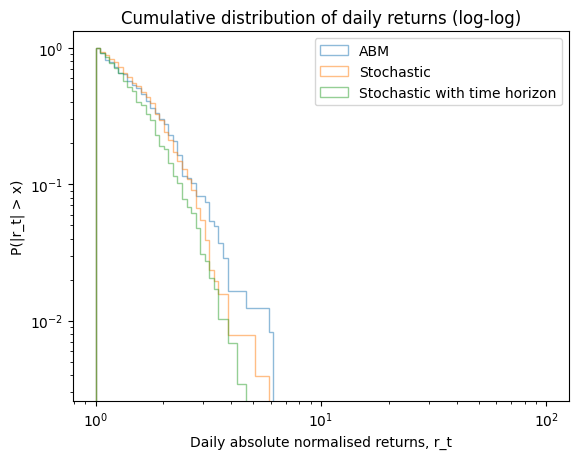

In [40]:
bin = np.logspace(0,2, 100)
plt.figure(1)
for i in range(len(data_returns)):
    plt.hist(data_returns[i], bins = bin, log=True, density = True, cumulative=-1, alpha=0.5, histtype='step', label=labels[i])
plt.legend(loc='upper right')
plt.xlabel('Daily absolute normalised returns, r_t')
plt.ylabel('P(|r_t| > x)')
plt.title("Cumulative distribution of daily returns (log-log)")
plt.gca().set_xscale("log")
plt.show()


In [41]:
plt.savefig('cumulative_distribution.png')

<Figure size 640x480 with 0 Axes>